## Introduction: 

Stationary Wavelet Transform (SWT) is a relatively straightforward method, but it has a particular disadvantage: it alters the original signal phase.
This happens because both highpass and lowpass filters that are used in SWT have phase information. Although the shift is confined to milliseconds, it is problematic and obviously undesirable in the application of event detection. Due to the phase shift propagating across the SWT scales, we expect the shift to get larger as the scale grows. Thus, the last detail and approximation will exhibit the greatest phase shift compared to the original input signal. Consequently, more information may be lost on higher scales. Accordingly, a particular event (or QRS complex in this example) are projected in different temporal locations at different levels of SWT detail coefficients, all of which are different from their original positions []. 

Professor Percival presented an elegant solution to this wavelet phase shift issue by introducing a zero-phase wavelet called Zephlet transform [1]. In this method, the wavelet filters undergo additional analysis to have their phase equal to zero. Therefore, with the filters not generating any phase shift at each scale, all the resulting coefficients would have zero phase shift with respect to the original signal. Furthermore, this transformation provides perfect reconstruction because Zephlet filters are designed in a way that they satisfy the wavelet filter requirements. Another benefit of complete synchrony among various Zephlet scales is the opportunity of incorporating information from these scales. 

In the following, you can find a customized wavelet object, which applies the Zephlet transform and generates the Zephlet filters from a chosen mother wavelet. 

Please feel free to use this code for your application. If you did so, please cite these two papers:

[1] Heydari Beni, Nargess and Jiang, Ning, Heartbeat Detection from High-Density EMG Electrodes on the Upper Arm at Different EMG Intensity Levels Using Zephlet. Available at SSRN: https://ssrn.com/abstract=4221592 or http://dx.doi.org/10.2139/ssrn.4221592
[2] Percival, Donald, Discrete wavelet transforms based on zero-phase Daubechies filters. Info-Metrics Institute Conference, http://faculty.washington.edu/dbp/PDFFILES/zephlet, 2010.

In [2]:
class ZephletFilter(object): 
    def __init__(self,Wname):
        self.Wname = Wname
    @property
    def filter_bank(self):
        import numpy as np, pywt, math, matplotlib.pyplot as plt
       
        wavelet = pywt.Wavelet(Wname)
        
        # calculating the absolute value of the fft for each of highpass and lowpass filters:

        low_absfft = np.abs(np.fft.fft(wavelet.dec_lo))
        high_absfft = np.abs(np.fft.fft(wavelet.dec_hi))

        low_realfft=np.fft.ifft(low_absfft).real
        high_realfft=np.fft.ifft(high_absfft).real
        
        low_len, = np.shape(low_realfft)
        high_len, = np.shape(high_realfft)

        filter_lowpass = np.append(low_realfft[math.floor(low_len/2):low_len],low_realfft[0:math.floor(low_len/2)])
        filter_highpass = np.append(high_realfft[math.floor(high_len/2):high_len], high_realfft[0:math.floor(high_len/2)])
        
        # updating the decomposition filters' amplitude:

        low_dec = filter_lowpass * np.sqrt(2)
        high_dec = filter_highpass * np.sqrt(2)

        # plotting the filters:
        #plt.plot(low_dec)
        #plt.plot(high_dec)
        #plt.show()

        # calculating the reconstruction filters based on decomposition filters:

        low_rec = np.flip(filter_lowpass)
        high_rec = np.flip(filter_highpass)

        # calculating the reconstruction filters' amplitude:

        low_rec = low_rec / np.sqrt(2)
        high_rec = high_rec / np.sqrt(2)

        return [low_dec, high_dec, low_rec, high_rec]     



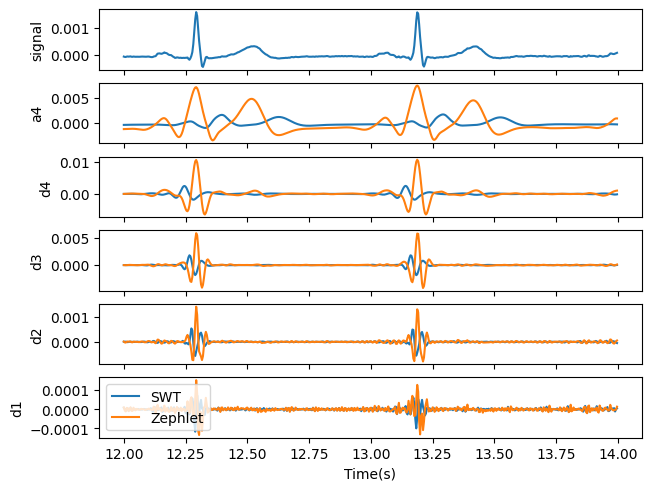

In [3]:
# example:

import numpy as np
import pywt
import math
import matplotlib.pyplot as plt
import pandas as pd


Wname = 'db4'
filter_bank = ZephletFilter(Wname)

myWavelet = pywt.Wavelet(name="myZephlet", filter_bank=filter_bank)

df = pd.read_csv(r'D:\Python\Zephlet\ecg_sec.csv')
level=4

# Extracting the Zephlet details:

Zph_sig = pywt.swt(np.transpose(df[0:int((np.floor(np.size(df,0)/np.power(2,level))*np.power(2,level)))]),myWavelet,level=level,trim_approx=True)
Zph_arr = np.squeeze(np.array(Zph_sig))
swt_sig = pywt.swt(np.transpose(df[0:int((np.floor(np.size(df,0)/np.power(2,level))*np.power(2,level)))]),Wname,level=level,trim_approx=True)
swt_arr = np.squeeze(np.array(swt_sig))

# plotting the details:

time_start = 12
time_finish = 14
fs = 256
fig, axs = plt.subplots(6,1, constrained_layout=True)
#fig, axs = plt.subplot_mosaic(['signal', 'a5', 'd5', 'd4','d3','d2','d1'], constrained_layout=True)
time_range = np.arange(time_start, time_finish, 1/fs)

# plotting the input signal and extracted details:

axs[0].plot(time_range, df[fs*time_start:fs*time_finish])
axs[0].set_ylabel('signal')
axs[0].set(xticklabels=[])
#axs[1].plot(time_range, swt_arr[1,fs*time_start:fs*time_finish])
#axs[1].set_ylabel('a5')
#axs[1].set(xticklabels=[])
ylabels = ['a4', 'd4','d3','d2','d1']

for i in range(0,4):
    axs[i+1].plot(time_range, swt_arr[i,fs*time_start:fs*time_finish])
    axs[i+1].plot(time_range, Zph_arr[i,fs*time_start:fs*time_finish])
    axs[i+1].set_ylabel(ylabels[i])
    #axs[i].set_ylabel("d"+str(5-i+1))
    axs[i+1].set(xticklabels=[])

axs[i+2].plot(time_range, swt_arr[i+1,fs*time_start:fs*time_finish], label='SWT')
axs[i+2].plot(time_range, Zph_arr[i+1,fs*time_start:fs*time_finish], label='Zephlet')
axs[i+2].set_ylabel(ylabels[i+1])
axs[i+2].legend()
plt.xlabel("Time(s)")
plt.show()



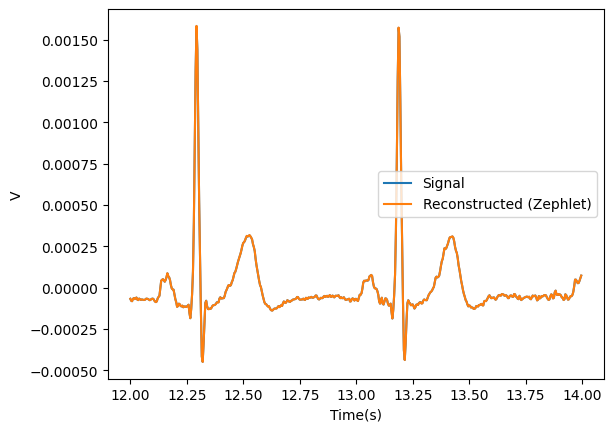

In [4]:
# reconstructing the details
iZph_sig = pywt.iswt(np.squeeze(Zph_sig),myWavelet)

# checking the complete reconstruction:
plt.plot(time_range, df[fs*time_start:fs*time_finish], label='Signal')
plt.plot(time_range, iZph_sig[fs*time_start:fs*time_finish], label='Reconstructed (Zephlet)')
plt.legend()
plt.xlabel("Time(s)")
plt.ylabel("V")
plt.show()
